In [1]:
import os
import random
import time
import pandas as pd
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import confusion_matrix ,classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
data_dir = os.path.join(os.getcwd(),'images-data-64/tifinagh-images/')
#print(data_dir)
current_working_directory = os.getcwd ()
#print(current_working_directory )

# Charger le fichier CSV contenant les etiquettes
try:
    labels_df = pd.read_csv(os.path.join(os.getcwd(),'images-data-64/labels-map.csv'))
    
    assert 'image_path' in labels_df.columns and 'label' in labels_df.columns, "CSV must contain 'image_path' and 'label' columns"
except FileNotFoundError : 
    print ("labels-map.csv not found. Please check the dataset structure.")

    # Alternative : construire un DataFrame partir des dossiers
                        
    image_paths = []
    labels = []

    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                image_paths.append(os.path.join(label_path, img_name))
                labels.append(label_dir)

    # Créer le DataFrame
    labels_df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Vérifier le DataFrame
assert not labels_df.empty, "No data loaded. Check dataset files."
print(f"Loaded {len(labels_df)} samples with {labels_df['label'].nunique()} unique classes.")

# Encoder les étiquettes
label_encoder = LabelEncoder()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
num_classes = len(label_encoder.classes_)

# Fonction pour charger et prétraiter une image
def load_and_preprocess_image(image_path, target_size=(32, 32)):
    """
    Load and preprocess an image: convert to grayscale, resize, normalize
    """
    assert os.path.exists(image_path), f"Image not found: {image_path}"
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    assert img is not None, f"Failed to load image: {image_path}"
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0  # Normalisation
    return img.flatten()  # Aplatir pour le réseau de neurones

# Charger toutes les images
X = np.array([load_and_preprocess_image(path) for path in labels_df['image_path']])
y = labels_df['label_encoded'].values
# Vérifier les dimensions
assert X.shape [0] == y.shape[0] , " Mismatch between number of images and labels "
assert X.shape [1] == 32 * 32 , f" Expected flattened image size of {32*32} , got {X.shape [1]} "
one_hot_encoder = OneHotEncoder(sparse=False)

y_one_hot = one_hot_encoder.fit_transform(y.reshape(-1, 1))

X_temp, X_test, y_temp, y_test = train_test_split(X, y_one_hot, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=np.argmax(y_temp, axis=1), random_state=42)

# Diviser en ensembles d'entrainement , validation et test
#X_temp , X_test , y_temp , y_test = train_test_split (X , y , test_size =0.2 , stratify =y , random_state =42)
#X_train , X_val , y_train , y_val = train_test_split ( X_temp , y_temp , test_size =0.25 , stratify = y_temp , random_state =42)

# Convertir explicitement en NumPy arrays
X_train = np.array ( X_train )
X_val = np.array ( X_val )
X_test = np.array ( X_test )
y_train = np.array ( y_train )
y_val = np.array ( y_val )
y_test = np.array (y_test )

assert X_train.shape [0] + X_val.shape [0] + X_test.shape [0] == X.shape [0] , "Train-val-test split sizes must sum to total samples"
print (f" Train : { X_train.shape [0]} samples , Validation : { X_val.shape [0]} samples , Test : { X_test.shape [0]} samples ")

# Encoder les étiquettes en one-hot pour la classification multiclasse
one_hot_encoder = OneHotEncoder(sparse=False)
y_train_one_hot = np.array(one_hot_encoder.fit_transform(y_train.reshape(-1, 1)))
y_val_one_hot = np.array(one_hot_encoder.transform(y_val.reshape(-1, 1)))
y_test_one_hot = np.array(one_hot_encoder.transform(y_test.reshape(-1, 1)))


# Vérifier que les tableaux one-hot sont bien des tableaux NumPy
assert isinstance(y_train_one_hot, np.ndarray), "y_train_one_hot must be a numpy array"
assert isinstance(y_val_one_hot, np.ndarray), "y_val_one_hot must be a numpy array"
assert isinstance(y_test_one_hot, np.ndarray), "y_test_one_hot must be a numpy array"

Loaded 28182 samples with 33 unique classes.
 Train : 16908 samples , Validation : 5637 samples , Test : 5637 samples 


In [23]:
import numpy as np

# Activation functions
def relu(x):
    """
    ReLU activation: max(0, x)
    """
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)
    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

def relu_derivative(x):
    """
    Derivative of ReLU: 1 if x > 0, else 0
    """
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = (x > 0).astype(int)
    assert np.all((result == 0) | (result == 1)), "ReLU derivative must be 0 or 1"
    return result

def Softmax(x):
    """
    Softmax activation : exp (x) / sum ( exp (x))
    """
    assert isinstance (x , np.ndarray ) , " Input to softmax must be a numpy array"
    exp_x = np.exp(x)
    result = exp_x / np.sum(exp_x, axis = 1, keepdims = True)
    assert np.all((result >= 0) & (result <= 1)),"Softmax output must be in [0,1]"
    assert np.allclose(np.sum(result, axis =1) , 1) , " Softmax output must sum to 1 per sample "
    return result
Softmax(np.array([[1,0],[0,1]]))

array([[0.73105858, 0.26894142],
       [0.26894142, 0.73105858]])

In [24]:
class MultiClassNeuralNetwork :
    
    def __init__(self,layer_sizes, learning_rate = 0.01, l2_lambda=0.0, optimizer="SGD"):
        """
        Initialize the neural network with given layer sizes and learning rate .
        layer_sizes : List of integers [ input_size , hidden1_size ,... , output_size ]

        """
        assert isinstance(layer_sizes,list) and len (layer_sizes)>= 2 ,"layer_sizes must be a list with at least 2 elements"
        assert all(isinstance (size,int) and size > 0 for size in layer_sizes),"All layer sizes must be positive integers"
        assert isinstance(learning_rate,(int,float)) and learning_rate > 0, " Learning rate must be a positive number "
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.l2_lambda=l2_lambda
        self.weights = []
        self.biases = []
        self.optimizer = optimizer
        np.random.seed(42)
        for i in range(len(self.layer_sizes)-1):
            w = np.random.randn(self.layer_sizes[i],self.layer_sizes[i+1]) * 0.01
            b = np.random.randn(1,self.layer_sizes[i+1])
            assert w.shape == (layer_sizes[i],layer_sizes[i+1]),f"Weight matrix {i+1} has incorrect shape"
            assert b.shape == (1,layer_sizes [i+1]),f"Bias vector{i+1} has incorrect shape "
            self.weights.append(w)
            self.biases.append(b)
        self.momentum = 0.9
        self.v_weights = [np.zeros_like(w) for w in self.weights]
        self.v_biases = [np.zeros_like(b) for b in self.biases]
        
    def forward(self, X):
        """
        Forward propagation: Z^{[l]} = A^{[l-1]}W^{[l]} + b^{[l]}, A^{[l]} = g(Z^{[l]})
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        self.z_values = []
        self.activations = [X]

        # Couches cachées avec ReLU
        for i in range(len(self.layer_sizes) - 2):
            z = self.activations[i] @ self.weights[i] + self.biases[i]
            assert z.shape == (X.shape[0], self.layer_sizes[i+1]), f"Z^{i+1} has incorrect shape"
            a = relu(z)
            self.z_values.append(z)
            self.activations.append(a)

        # Dernière couche avec Softmax
        z = self.activations[-1] @ self.weights[-1] + self.biases[-1]
        assert z.shape == (X.shape[0], self.layer_sizes[-1]), "Output Z has incorrect shape"
        output = Softmax(z)
        assert output.shape == (X.shape[0], self.layer_sizes[-1]), "Output A has incorrect shape"
        self.z_values.append(z)
        self.activations.append(output)

        return self.activations[-1]

    def compute_loss(self, y_true, y_pred):
        """
        Categorical Cross-Entropy: J = -1/m * sum(y_true * log(y_pred))
        """
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to loss must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        assert not np.isnan(loss), "Loss computation resulted in NaN"
        return loss
    def compute_accuracy(self, y_true, y_pred):
        """
        Compute accuracy: proportion of correct predictions
        """
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to accuracy must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

        predictions = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_true, axis=1)
        accuracy = np.mean(predictions == true_labels)

        assert 0 <= accuracy <= 1, "Accuracy must be between 0 and 1"
        #print("accuracy = ",accuracy)
        return accuracy

    def backward(self,X,y,outputs):
        """
        Backpropagation: compute dW^{[l]}, db^{[l]} for each layer
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs, np.ndarray), "Inputs to backward must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape == outputs.shape, "y and outputs must have the same shape"
        
        m = X.shape[0]
        self.d_weights = [None] * len(self.weights)
        self.d_biases = [None] * len(self.biases)
        
        dZ = outputs - y
        assert dZ.shape == outputs.shape , "dZ for output layer has incorrect shape"
        self.d_weights[-1] = (self.activations [-2].T @ dZ) / m
        self.d_biases[-1] = np.sum(dZ ,axis=0 , keepdims = True) / m
        
        for l in range(len(self.weights)-2,-1,-1 ):
            dZ = (dZ @ self.weights[l+1].T) * relu_derivative(self.z_values[l])
            assert dZ.shape == (X.shape [0] , self.layer_sizes[l +1]), f"dZ ^{[ i +1]} has incorrect shape"
            self.d_weights[l] = (self.activations [l].T @ dZ) / m
            self.d_biases[l] = np.sum(dZ ,axis=0 , keepdims = True) / m   
            
        # Optimisation
        beta1 = 0.9
        beta2 = 0.999
        epsilon = 1e-8
        for i in range(len(self.weights)):

            # Ajout régularisation L2
            self.d_weights[i] += (self.l2_lambda * self.weights[i]) / m

            if self.optimizer == "momentum":
                self.v_weights[i] = self.momentum * self.v_weights[i] - self.learning_rate * self.d_weights[i]
                self.v_biases[i] = self.momentum * self.v_biases[i] - self.learning_rate * self.d_biases[i]

            elif self.optimizer == "rmsprop":
                if not hasattr(self, 's_weights'):
                    self.s_weights = [np.zeros_like(w) for w in self.weights]
                    self.s_biases = [np.zeros_like(b) for b in self.biases]
                self.s_weights[i] = beta1 * self.s_weights[i] + (1 - beta1) * self.d_weights[i]**2
                self.s_biases[i] = beta1 * self.s_biases[i] + (1 - beta1) * self.d_biases[i]**2
                self.v_weights[i] = -self.learning_rate * self.d_weights[i] / (np.sqrt(self.s_weights[i]) + epsilon)
                self.v_biases[i] = -self.learning_rate * self.d_biases[i] / (np.sqrt(self.s_biases[i]) + epsilon)

            elif self.optimizer == "adam":
                if not hasattr(self, 'm_weights'):
                    self.m_weights = [np.zeros_like(w) for w in self.weights]
                    self.vw_weights = [np.zeros_like(w) for w in self.weights]
                    self.m_biases = [np.zeros_like(b) for b in self.biases]
                    self.vw_biases = [np.zeros_like(b) for b in self.biases]
                    self.t = 0
                self.t += 1
                self.m_weights[i] = beta1 * self.m_weights[i] + (1 - beta1) * self.d_weights[i]
                self.vw_weights[i] = beta2 * self.vw_weights[i] + (1 - beta2) * (self.d_weights[i] ** 2)
                m_corr = self.m_weights[i] / (1 - beta1 ** self.t)
                v_corr = self.vw_weights[i] / (1 - beta2 ** self.t)
                self.v_weights[i] = -self.learning_rate * m_corr / (np.sqrt(v_corr) + epsilon)

                self.m_biases[i] = beta1 * self.m_biases[i] + (1 - beta1) * self.d_biases[i]
                self.vw_biases[i] = beta2 * self.vw_biases[i] + (1 - beta2) * (self.d_biases[i] ** 2)
                mb_corr = self.m_biases[i] / (1 - beta1 ** self.t)
                vb_corr = self.vw_biases[i] / (1 - beta2 ** self.t)
                self.v_biases[i] = -self.learning_rate * mb_corr / (np.sqrt(vb_corr) + epsilon)

            else:  # SGD par défaut
                self.v_weights[i] = -self.learning_rate * self.d_weights[i]
                self.v_biases[i] = -self.learning_rate * self.d_biases[i]

            # Mise à jour finale des poids
            self.weights[i] += self.v_weights[i]
            self.biases[i] += self.v_biases[i]         
            
    def train(self, X, y, X_val, y_val, epochs, batch_size):
        """
        Train the neural network using mini-batch SGD, with validation
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
        assert isinstance(X_val, np.ndarray) and isinstance(y_val, np.ndarray), "X_val and y_val must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape[1] == self.layer_sizes[-1], f"Output dimension ({y.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert X_val.shape[1] == self.layer_sizes[0], f"Validation input dimension ({X_val.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y_val.shape[1] == self.layer_sizes[-1], f"Validation output dimension ({y_val.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert isinstance(epochs, int) and epochs > 0, "Epochs must be a positive integer"
        assert isinstance(batch_size, int) and batch_size > 0, "Batch size must be a positive integer"

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0]) # indice aleatoire represente une image alétoire = vecteur de meme taille que x_train
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size): # 0 1024 32
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs)

            # Calculer les pertes et accuracies
            train_loss = epoch_loss / (X.shape[0] // batch_size)
            train_pred = self.forward(X)
            train_accuracy = self.compute_accuracy(y, train_pred)
            val_pred = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_pred)
            val_accuracy = self.compute_accuracy(y_val, val_pred)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if epoch % 20 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}") 

        return train_losses , val_losses , train_accuracies ,val_accuracies

    def predict(self,X):
        """
        Predict class labels
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"

        outputs = self.forward(X)
        predictions = np.argmax(outputs, axis=1)
        assert predictions.shape == (X.shape[0],), "Predictions have incorrect shape"
        return predictions
                           

### First Configuration with regularization and optimizer methods

In [25]:
# Créer et entraîner le modèle
layer_sizes = [X_train.shape[1], 64, 32, num_classes]  # 64 et 32 neurones cachés, 33 classes
nn = MultiClassNeuralNetwork(layer_sizes, learning_rate=0.01, l2_lambda = 0.01,optimizer="adam")
train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
#    X_train, y_train_one_hot, X_val, y_val_one_hot, epochs=100, batch_size=32)

In [ ]:

# Prédictions et évaluation
y_pred = nn.predict(X_test)
print("\nRapport de classification (Test set):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('confusion Matrix (Test set) with Adam optimizer & lr=0.01'  )
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.savefig('images/confusion_matrix_adam_L2_0_001_lr_0.01_cv.png')
plt.close()

# Courbes de perte et d’accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Courbe de perte
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Loss curve with Adam optimizer & lr=0.01_cv')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Courbe de précision
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Precision curve with Adam optimizer & lr=0.01_cv')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Precision')
ax2.legend()
plt.show()
plt.tight_layout()
fig.savefig('images/loss_accuracy_plot_adam_L2_0_01_lr_0.001_cv.png')
plt.close()


### Second Configuration with cross validation

In [58]:
from sklearn.model_selection import KFold
import numpy as np

def cross_validate(model_class, X, y_one_hot, k=5, epochs=100, batch_size=32, **model_kwargs):
    """
    Effectue une validation croisée K-fold sur un modèle MultiClassNeuralNetwork.
    
    Parameters:
        model_class: la classe du modèle à instancier (ex: MultiClassNeuralNetwork)
        X (np.ndarray): données d'entrée (features)
        y_one_hot (np.ndarray): étiquettes one-hot (n_samples, n_classes)
        k (int): nombre de folds
        epochs (int): nombre d'époques par fold
        batch_size (int): taille des mini-lots
        model_kwargs: hyperparamètres pour initialiser le modèle
    
    Returns:
        Moyenne des précisions et pertes sur les folds
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    val_accuracies = []
    val_losses = []
    train_accuracies = []
    train_losses = []

    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}/{k}")
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y_one_hot[train_index], y_one_hot[val_index]

        model = model_class(**model_kwargs)
        train_loss, val_loss, train_accuracy, val_accuracy = model.train(X_train, y_train, X_val, y_val, epochs, batch_size)

        val_accuracies.append(val_accuracy)
        print(len(val_accuracies[0]))
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
    
    print(f"\nMoyenne des précisions de validation : {np.mean(val_accuracies):.4f}")
    print(f"Moyenne des pertes de validation : {np.mean(val_losses):.4f}")
    print(f"\nMoyenne des précisions d'entrainement : {np.mean(train_accuracies):.4f}")
    print(f"Moyenne des pertes d'entrainement : {np.mean(train_losses):.4f}")

    return  train_losses,val_losses, train_accuracies, val_accuracies


In [65]:
num_classes = y_one_hot.shape[1]
print(num_classes)
print(y_train_one_hot.shape)
model_args = {
    'layer_sizes': [X.shape[1], 64, 32, num_classes],
    'learning_rate': 0.01,
    'optimizer': 'rmsprop',
    'l2_lambda': 0.01
}

train_losses, val_losses, train_accuracies, val_accuracies = cross_validate(MultiClassNeuralNetwork, X, y_one_hot, k=5, epochs=50, batch_size=32, **model_args)

33
(557964, 2)

Fold 1/5
Epoch 0, Train Loss: 1.7451, Validation Loss: 1.2340, Train Acc: 0.6106, Val Acc: 0.5918
Epoch 20, Train Loss: 0.5843, Validation Loss: 0.9334, Train Acc: 0.7892, Val Acc: 0.7603
Epoch 40, Train Loss: 0.5484, Validation Loss: 0.6577, Train Acc: 0.8356, Val Acc: 0.8063
50

Fold 2/5
Epoch 0, Train Loss: 1.7280, Validation Loss: 1.2183, Train Acc: 0.6323, Val Acc: 0.6186
Epoch 20, Train Loss: 0.6143, Validation Loss: 0.7341, Train Acc: 0.8072, Val Acc: 0.7861
Epoch 40, Train Loss: 0.5817, Validation Loss: 0.8202, Train Acc: 0.7872, Val Acc: 0.7575
50

Fold 3/5
Epoch 0, Train Loss: 1.6886, Validation Loss: 1.0859, Train Acc: 0.6666, Val Acc: 0.6489
Epoch 20, Train Loss: 0.5874, Validation Loss: 0.6667, Train Acc: 0.8354, Val Acc: 0.7986
Epoch 40, Train Loss: 0.5298, Validation Loss: 0.6016, Train Acc: 0.8488, Val Acc: 0.8128
50

Fold 4/5
Epoch 0, Train Loss: 1.7380, Validation Loss: 1.1057, Train Acc: 0.6539, Val Acc: 0.6384
Epoch 20, Train Loss: 0.6050, Validation

5


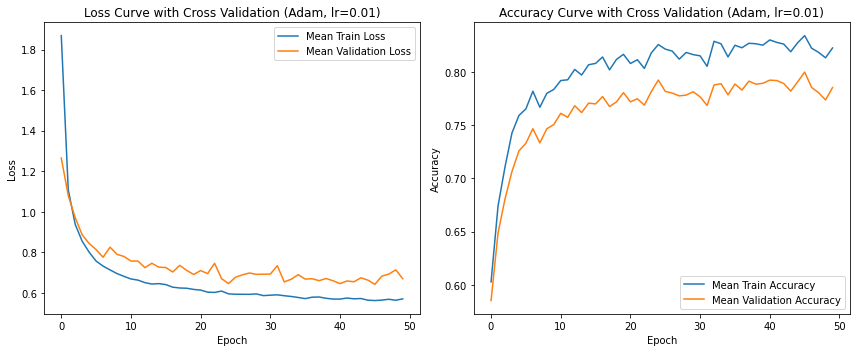

In [64]:
# Calcul des moyennes par époque (axis=0 correspond à la dimension epochs)
mean_train_losses = np.mean(train_losses, axis=0)
mean_val_losses = np.mean(val_losses, axis=0)
mean_train_accs = np.mean(train_accuracies, axis=0)
mean_val_accs = np.mean(val_accuracies, axis=0)
print(len(train_losses))


# Tracé des courbes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Courbes de perte (loss)
ax1.plot(mean_train_losses, label='Mean Train Loss')
ax1.plot(mean_val_losses, label='Mean Validation Loss')
ax1.set_title('Loss Curve with Cross Validation (RMSProp, lr=0.01)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Courbes de précision (accuracy)
ax2.plot(mean_train_accs, label='Mean Train Accuracy')
ax2.plot(mean_val_accs, label='Mean Validation Accuracy')
ax2.set_title('Accuracy Curve with Cross Validation (RMSProp, lr=0.01)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
fig.savefig('images/loss_accuracy_plot_rmsprop_L2_0_01_lr_0_01_cv.png')
plt.show()

5


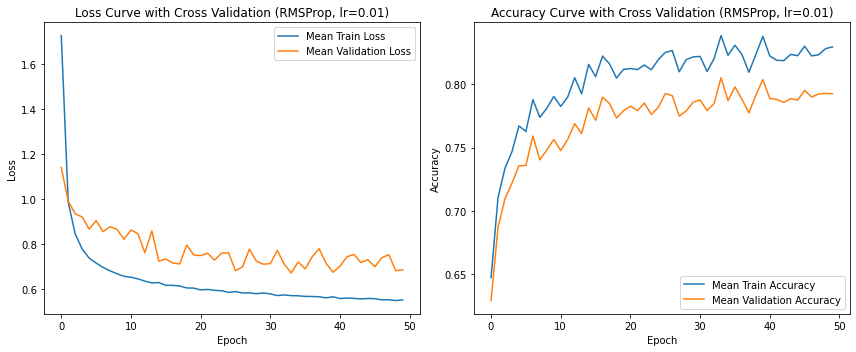

In [66]:
# Calcul des moyennes par époque (axis=0 correspond à la dimension epochs)
mean_train_losses = np.mean(train_losses, axis=0)
mean_val_losses = np.mean(val_losses, axis=0)
mean_train_accs = np.mean(train_accuracies, axis=0)
mean_val_accs = np.mean(val_accuracies, axis=0)
print(len(train_losses))


# Tracé des courbes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Courbes de perte (loss)
ax1.plot(mean_train_losses, label='Mean Train Loss')
ax1.plot(mean_val_losses, label='Mean Validation Loss')
ax1.set_title('Loss Curve with Cross Validation (RMSProp, lr=0.01)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Courbes de précision (accuracy)
ax2.plot(mean_train_accs, label='Mean Train Accuracy')
ax2.plot(mean_val_accs, label='Mean Validation Accuracy')
ax2.set_title('Accuracy Curve with Cross Validation (RMSProp, lr=0.01)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
fig.savefig('images/loss_accuracy_plot_rmsprop_L2_0_01_lr_0_01_cv.png')
plt.show()

# Data Augmentation

In [ ]:
import random

def augment_image(img):
    """
    Apply random rotation and translation to the image.
    """
    rows, cols = img.shape

    # Random rotation between -15 and 15 degrees
    angle = random.uniform(-15, 15)
    M_rot = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)

    # Random translation between -3 and 3 pixels
    tx = random.uniform(-3, 3)
    ty = random.uniform(-3, 3)
    M_trans = np.float32([[1, 0, tx], [0, 1, ty]])

    # Apply rotation then translation
    img_rotated = cv2.warpAffine(img, M_rot, (cols, rows), borderMode=cv2.BORDER_REFLECT)
    img_translated = cv2.warpAffine(img_rotated, M_trans, (cols, rows), borderMode=cv2.BORDER_REFLECT)

    return img_translated


In [ ]:
def load_and_preprocess_image(image_path, target_size=(32, 32), augment=False):
    """
    Load and preprocess an image: convert to grayscale, resize, normalize, optionally augment.
    """
    assert os.path.exists(image_path), f"Image not found: {image_path}"
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    assert img is not None, f"Failed to load image: {image_path}"
    img = cv2.resize(img, target_size)

    if augment:
        img = augment_image(img)

    img = img.astype(np.float32) / 255.0
    return img.flatten()


In [ ]:
data_dir = os.path.join(os.getcwd(),'images-data-64/tifinagh-images/')
#print(data_dir)
current_working_directory = os.getcwd ()
#print(current_working_directory )

# Charger le fichier CSV contenant les etiquettes
try:
    labels_df = pd.read_csv(os.path.join(os.getcwd(),'images-data-64/labels-map.csv'))
    
    assert 'image_path' in labels_df.columns and 'label' in labels_df.columns, "CSV must contain 'image_path' and 'label' columns"
except FileNotFoundError : 
    print ("labels-map.csv not found. Please check the dataset structure.")

    # Alternative : construire un DataFrame partir des dossiers
                        
    image_paths = []
    labels = []

    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                image_paths.append(os.path.join(label_path, img_name))
                labels.append(label_dir)

    # Créer le DataFrame
    labels_df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Vérifier le DataFrame
assert not labels_df.empty, "No data loaded. Check dataset files."
print(f"Loaded {len(labels_df)} samples with {labels_df['label'].nunique()} unique classes.")

# Encoder les étiquettes
label_encoder = LabelEncoder()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
num_classes = len(label_encoder.classes_)

# Charger toutes les images
X = np.array([load_and_preprocess_image(path) for path in labels_df['image_path']])
y = labels_df['label_encoded'].values
# Vérifier les dimensions
assert X.shape [0] == y.shape[0] , " Mismatch between number of images and labels "
assert X.shape [1] == 32 * 32 , f" Expected flattened image size of {32*32} , got {X.shape [1]} "
one_hot_encoder = OneHotEncoder(sparse=False)

y_one_hot = one_hot_encoder.fit_transform(y.reshape(-1, 1))

X_temp, X_test, y_temp, y_test = train_test_split(X, y_one_hot, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=np.argmax(y_temp, axis=1), random_state=42)

# Diviser en ensembles d'entrainement , validation et test
#X_temp , X_test , y_temp , y_test = train_test_split (X , y , test_size =0.2 , stratify =y , random_state =42)
#X_train , X_val , y_train , y_val = train_test_split ( X_temp , y_temp , test_size =0.25 , stratify = y_temp , random_state =42)

# Convertir explicitement en NumPy arrays
X_train = np.array ( X_train )
X_val = np.array ( X_val )
X_test = np.array ( X_test )
y_train = np.array ( y_train )
y_val = np.array ( y_val )
y_test = np.array (y_test )

assert X_train.shape [0] + X_val.shape [0] + X_test.shape [0] == X.shape [0] , "Train-val-test split sizes must sum to total samples"
print (f" Train : { X_train.shape [0]} samples , Validation : { X_val.shape [0]} samples , Test : { X_test.shape [0]} samples ")

# Encoder les étiquettes en one-hot pour la classification multiclasse
one_hot_encoder = OneHotEncoder(sparse=False)
y_train_one_hot = np.array(one_hot_encoder.fit_transform(y_train.reshape(-1, 1)))
y_val_one_hot = np.array(one_hot_encoder.transform(y_val.reshape(-1, 1)))
y_test_one_hot = np.array(one_hot_encoder.transform(y_test.reshape(-1, 1)))


# Vérifier que les tableaux one-hot sont bien des tableaux NumPy
assert isinstance(y_train_one_hot, np.ndarray), "y_train_one_hot must be a numpy array"
assert isinstance(y_val_one_hot, np.ndarray), "y_val_one_hot must be a numpy array"
assert isinstance(y_test_one_hot, np.ndarray), "y_test_one_hot must be a numpy array"